To train our detector we take the following steps:

* Install Detectron2 dependencies
* Download custom Detectron2 object detection data
* Visualize Detectron2 training data
* Write our Detectron2 Training configuration
* Run Detectron2 training
* Evaluate Detectron2 performance
* Run Detectron2 inference on test images


# Install Detectron2 Dependencies

In [1]:
#use this command to see GPU activity while doing Deep Learning tasks, 
#for this command 'nvidia-smi' and for above one to work, 
#go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

Tue Feb 28 09:23:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    31W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!gcc --version
# opencv is pre-installed on colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.8/703.8 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 29.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.1 requires torch==1.13.1, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.13.1+cu116 requires t

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [9]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html


In [10]:
# Some basic setup:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import cv2
import random
import numpy as np
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

1.5.0+cu101 True


# Import and Register Custom Detectron2 Data

In [11]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ExBvJx4lwNIvKZjT7qFf")
project = rf.workspace("riga-technical-university").project("skin-cancer-v3")
dataset = project.version(1).download("coco")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.2/701.2 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=6019b9c814fc8d013063ece37b4a4a122216b979f9d7b9e73b4649b0f9365734
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: P

Extracting Dataset Version Zip to Skin-cancer-v3-1 in coco:: 100%|██████████| 1208/1208 [00:09<00:00, 132.33it/s]


In [12]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("custom_skin_lesion_train", {}, "/content/drive/MyDrive/Skin-cancer-v3-1/train/_annotations.coco.json", "/content/drive/MyDrive/Skin-cancer-v3-1/train")
register_coco_instances("custom_skin_lesion_val", {}, "/content/drive/MyDrive/Skin-cancer-v3-1/valid/_annotations.coco.json", "/content/drive/MyDrive/Skin-cancer-v3-1/valid")
register_coco_instances("custom_skin_lesion__test", {}, "/content/drive/MyDrive/Skin-cancer-v3-1/test/_annotations.coco.json", "/content/drive/MyDrive/Skin-cancer-v3-1/test")

In [ ]:
## Check the registered datasets with Detectron2
#DatasetCatalog._REGISTERED

In [ ]:
## Example of how to remove registered datasets (uncomment only if you need to)
#DatasetCatalog._REGISTERED.pop('custom_train') # remove our training dataset
#DatasetCatalog._REGISTERED.pop('custom_val') # remove our validation dataset
#DatasetCatalog._REGISTERED.pop('custom_test') # remove our test dataset

WARNING [02/28 09:28:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/28 09:28:47 d2.data.datasets.coco]: Loaded 1050 images in COCO format from /content/drive/MyDrive/Skin-cancer-v3-1/train/_annotations.coco.json


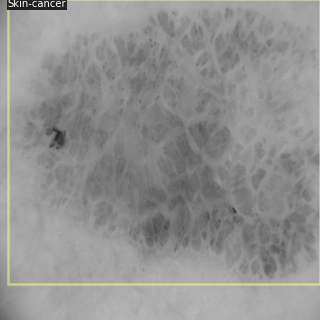

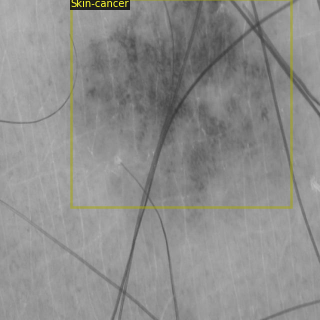

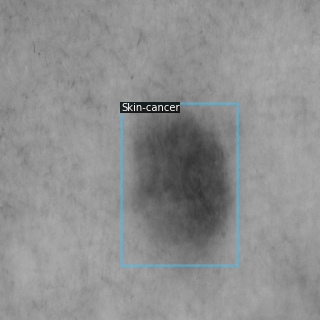

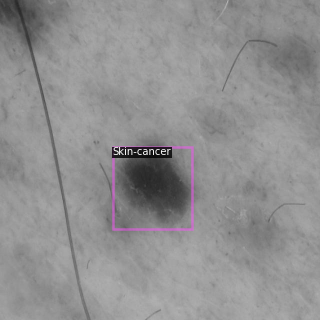

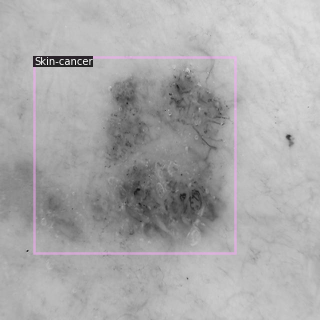

In [13]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("custom_skin_lesion_train")
dataset_dicts = DatasetCatalog.get("custom_skin_lesion_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Train Custom Detectron2 Detector

In [14]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [15]:
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("custom_skin_lesion_train",)
cfg.DATASETS.TEST = ("custom_skin_lesion_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001

cfg.SOLVER.WARMUP_ITERS = 5
cfg.SOLVER.MAX_ITER = 8 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (5, 8)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 #your number of classes

cfg.TEST.EVAL_PERIOD = 3

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/28 09:29:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:07, 59.0MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[02/28 09:29:23 d2.engine.train_loop]: Starting training from iteration 0
WARNING [02/28 09:29:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/28 09:29:29 d2.data.datasets.coco]: Loaded 100 images in COCO format from /content/drive/MyDrive/Skin-cancer-v3-1/valid/_annotations.coco.json
[02/28 09:29:29 d2.data.build]: Distribution of instances among all 2 categories:
|  category   | #instances   |  category   | #instances   |
|:-----------:|:-------------|:-----------:|:-------------|
| Skin-cancer | 0            | Skin-cancer | 102          |
|             |              |             |              |
|    total    | 102          |             |              |
[02/28 09:29:29 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[02/28 09:29:29 d2.data.common]: Serialized dataset takes 0.03 MiB
[02/28 09:29:29 d2.evaluation.evaluator]: Start inference on 100 images
[02/28 09:29:31

In [18]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("custom_skin_lesion__test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "custom_skin_lesion__test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [02/28 09:31:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/28 09:31:52 d2.data.datasets.coco]: Loaded 50 images in COCO format from /content/drive/MyDrive/Skin-cancer-v3-1/test/_annotations.coco.json
[02/28 09:31:52 d2.data.build]: Distribution of instances among all 2 categories:
|  category   | #instances   |  category   | #instances   |
|:-----------:|:-------------|:-----------:|:-------------|
| Skin-cancer | 0            | Skin-cancer | 50           |
|             |              |             |              |
|    total    | 50           |             |              |
[02/28 09:31:52 d2.data.common]: Serializing 50 elements to byte tensors and concatenating them all ...
[02/28 09:31:52 d2.data.common]: Serialized dataset takes 0.01 MiB
[02/28 09:31:52 d2.evaluation.evaluator]: Start inference on 50 images
[02/28 09:31:55 d2.evaluation.evaluator]: Inference done 11/50. 0.2628 s / img. ETA=0:00:10
[

OrderedDict([('bbox',
              {'AP': 0.0,
               'AP50': 0.0,
               'AP75': 0.0,
               'APs': nan,
               'APm': nan,
               'APl': 0.0,
               'AP-Skin-cancer': 0.0})])

# Inference with Detectron2 Saved Weights



In [19]:
%ls ./output/

coco_instances_results.json                        last_checkpoint
custom_skin_lesion_test_coco_format.json.lock      metrics.json
events.out.tfevents.1677576556.077831485eb8.221.0  model_final.pth
instances_predictions.pth


In [20]:
import os
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("custom_skin_lesion__test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("custom_skin_lesion__test")

WARNING [02/28 09:32:21 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/28 09:32:21 d2.data.datasets.coco]: Loaded 50 images in COCO format from /content/drive/MyDrive/Skin-cancer-v3-1/test/_annotations.coco.json


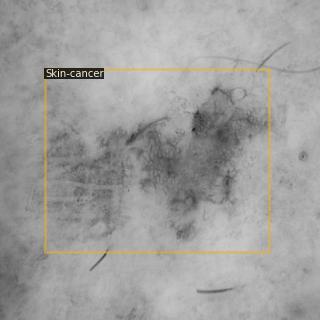

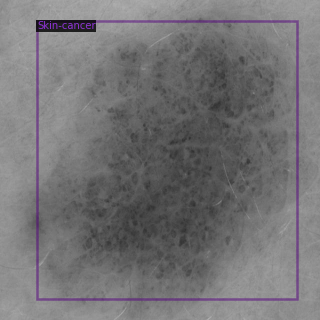

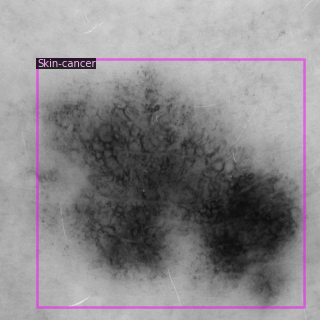

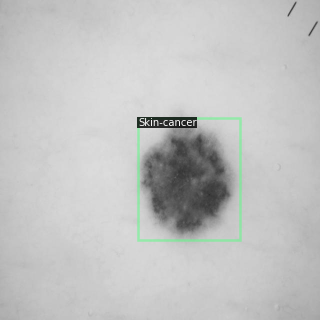

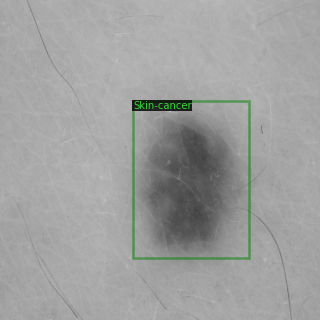

In [21]:
from detectron2.utils.visualizer import ColorMode
import glob

dataset_dicts = DatasetCatalog.get("custom_skin_lesion__test")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=test_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])


In [26]:
from detectron2.utils.visualizer import ColorMode
import glob

dataset_dicts = DatasetCatalog.get("custom_skin_lesion__test")

import random
from detectron2.structures import boxes
from detectron2.utils.visualizer import Visualizer, ColorMode

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=test_metadata, scale=0.5, instance_mode=ColorMode.IMAGE)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Compute IoU between predicted boxes and ground truth boxes
    pred_boxes = outputs["instances"].to("cpu").pred_boxes.tensor.numpy()
    gt_boxes = d["annotations"][0]["bbox"]
    iou = boxes.box_iou(pred_boxes, gt_boxes[np.newaxis, :])[0, 0]

    # Add IoU value as text annotation
    v.text(str(iou), (10, 10), color="white", fontsize=15)

    cv2.imshow("image", v.get_image()[:, :, ::-1])
    cv2.waitKey(0)

WARNING [02/28 09:40:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/28 09:40:15 d2.data.datasets.coco]: Loaded 50 images in COCO format from /content/drive/MyDrive/Skin-cancer-v3-1/test/_annotations.coco.json


AttributeError: ignored